In [115]:
from numpy import *

# SMO算法中的辅助函数
def loadDataSet(fileName):
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return dataMat, labelMat

def selectJrand(i, m):
    j = i
    while j == i:
        j = int(random.uniform(0, m))
    return j

def clipAlpha(aj, H, L):
    if aj > H: aj = H
    if L > aj: aj = L
    return aj

In [35]:
dataArr, labelArr = loadDataSet('testSet.txt')

In [36]:
labelArr

[-1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0]

In [37]:
# 简化版SMO算法
# @dataMat    ：数据列表
# @classLabels：标签列表
# @C          ：权衡因子（增加松弛因子而在目标优化函数中引入了惩罚项）
# @toler      ：容错率
# @maxIter    ：最大迭代次数
def smoSimple(dataMatIn, classLabels, C, toler,  maxIter):
    dataMatrix = mat(dataMatIn); labelMat = mat(classLabels).T
    b = 0; m,n = shape(dataMatrix)
    alphas = mat(zeros((m, 1)))
    iter = 0
    
    while iter < maxIter:
        alphaPairsChanged = 0
        for i in range(m):
            fXi = float(multiply(alphas, labelMat).T * (dataMatrix * dataMatrix[i,:].T)) + b # [i,:]取矩阵第i行
            Ei = fXi - float(labelMat[i])
            
            # 如果不满足KKT条件
            if (((labelMat[i]*Ei < -toler) and (alphas[i] < C)) or
                ((labelMat[i]*Ei > toler) and (alphas[i] > 0))):
                j = selectJrand(i, m)
                fXj = float(multiply(alphas, labelMat).T * (dataMatrix * dataMatrix[j,:].T)) + b
                Ej = fXj - float(labelMat[j])
                alphaIold = alphas[i].copy()
                alphaJold = alphas[j].copy()
                
                if labelMat[i] != labelMat[j]:
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                if L == H: print("L == H"); continue
                
                # 计算alpha值
                eta = (2.0 * dataMatrix[i, :] * dataMatrix[j, :].T - 
                       dataMatrix[i, :] * dataMatrix[i, :].T -
                       dataMatrix[j, :] * dataMatrix[j, :].T) # 计算η值
                if eta >= 0:  print("eta >= 0"); continue # 个人认为只需防止eta == 0即可，因η<= 0
                alphas[j] -= labelMat[j] * (Ei - Ej)/eta
                alphas[j] = clipAlpha(alphas[j], H, L)
                if abs(alphas[j] - alphaJold) < 0.00001: 
                    print("j not moving enough")
                    continue
                alphas[i] += labelMat[j] * labelMat[i] * (alphaJold - alphas[j])
                
                # 计算b
                b1 = (b - Ei - labelMat[i] * (alphas[i] - alphaIold) * 
                      dataMatrix[i, :] * dataMatrix[i, :].T - 
                      labelMat[j] * (alphas[j] - alphaJold) * 
                      dataMatrix[i, :] * dataMatrix[j, :].T)
                b2 = (b - Ej - labelMat[i] * (alphas[i] - alphaIold) *
                      dataMatrix[i, :] * dataMatrix[j, :].T - 
                      labelMat[j] * (alphas[j] - alphaJold) *
                      dataMatrix[j, :] * dataMatrix[j, :].T)
                if (0 < alphas[i]) and (C > alphas[i]): b = b1
                elif (0 < alphas[j]) and (C > alphas[j]): b = b2
                else: b = (b1 + b2) / 2.0
                
                alphaPairsChanged += 1
                print("iter: %d i: %d, pairs changed %d" % (iter, i, alphaPairsChanged))
        if alphaPairsChanged == 0: iter += 1
        else: iter = 0
        print("iteration number: %d" % iter)
    
    return b,alphas

In [38]:
b, alphas = smoSimple(dataArr, labelArr, 0.6, 0.001, 40) 

L == H
iter: 0 i: 1, pairs changed 1
j not moving enough
iter: 0 i: 4, pairs changed 2
L == H
L == H
L == H
j not moving enough
L == H
L == H
iter: 0 i: 23, pairs changed 3
iter: 0 i: 24, pairs changed 4
j not moving enough
j not moving enough
j not moving enough
L == H
L == H
j not moving enough
L == H
L == H
j not moving enough
j not moving enough
L == H
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
L == H
L == H
j not moving enough
L == H
j not moving enough
j not moving enough
L == H
j not moving enough
L == H
L == H
iter: 0 i: 69, pairs changed 1
L == H
j not moving enough
j not moving enough
L == H
L == H
j not moving enough
iteration number: 0
iter: 0 i: 0, pairs changed 1
j not moving enough
j not moving enough
L == H
j not moving enough
j not moving enough
L == H
j not moving enough
j not moving enough
j not moving enough
iter: 0 i: 29, pairs changed 2
j not moving enough
j not moving enough
L == H
j not moving enough
j not

j not moving enough
j not moving enough
iteration number: 0
iter: 0 i: 11, pairs changed 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L == H
j not moving enough
j not moving enough
iter: 0 i: 57, pairs changed 2
j not moving enough
L == H
j not moving enough
iteration number: 0
L == H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iter: 0 i: 30, pairs changed 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 0
j not moving enough
L == H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iter: 0 i: 39, pairs changed 1
j not moving enough
iter: 0 i: 54, pairs changed 2
j not moving enough
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
j not moving enou

j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
iter: 1 i: 23, pairs changed 1
j not moving enough
j not moving enough
j not moving enough
iter: 1 i: 55, pairs changed 2
iteration number: 0
j not moving enough
j not moving enough
iter: 0 i: 29, pairs changed 1
j not moving enough
j not moving enough
j not moving enough
iteration number: 0
j not moving enough
iter: 0 i: 52, pairs changed 1
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
iter: 1 i: 17, pairs changed 1
j not moving enough
j not moving enough
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
j not moving enough
j not moving enough
iteration number: 3
j not moving enough
j not moving enough
j not

j not moving enough
iteration number: 5
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 6
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 7
j not moving enough
L == H
j not moving enough
j not moving enough
iteration number: 8
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 9
iter: 9 i: 17, pairs changed 1
j not moving enough
j not moving enough
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
iter: 1 i: 55, pairs changed 1
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
j not moving enough
j not moving enough
iteration number: 3
j not moving enough
j not moving enough
j not movin

iteration number: 11
j not moving enough
j not moving enough
iteration number: 12
j not moving enough
j not moving enough
iteration number: 13
j not moving enough
j not moving enough
iteration number: 14
j not moving enough
j not moving enough
iteration number: 15
j not moving enough
j not moving enough
iteration number: 16
j not moving enough
j not moving enough
iteration number: 17
j not moving enough
j not moving enough
iteration number: 18
j not moving enough
j not moving enough
iteration number: 19
j not moving enough
j not moving enough
iteration number: 20
j not moving enough
j not moving enough
iteration number: 21
j not moving enough
j not moving enough
iteration number: 22
j not moving enough
j not moving enough
iteration number: 23
j not moving enough
j not moving enough
iteration number: 24
j not moving enough
j not moving enough
iteration number: 25
j not moving enough
j not moving enough
iteration number: 26
j not moving enough
j not moving enough
iteration number: 27
j n

In [39]:
b

matrix([[-3.96031691]])

In [40]:
alphas[alphas > 0] # 数组过滤，条件为：元素值 > 0

matrix([[0.10274413, 0.27109844, 0.02953754, 0.34430503]])

In [41]:
shape(alphas[alphas > 0])

(1, 4)

In [42]:
for i in range(100):
    if alphas[i] > 0.0: print(dataArr[i], labelArr[i])

[4.658191, 3.507396] -1.0
[3.457096, -0.082216] -1.0
[5.286862, -2.358286] 1.0
[6.080573, 0.418886] 1.0


In [43]:
# 分类结果可视化
def showClassifer(dataArr, w, b):
    import matplotlib.pyplot as plt
    # 绘制样本点
    data_plus = []                                  # 正样本
    data_minus = []                                 # 负样本
    for i in range(len(dataArr)):
        if labelArr[i] > 0:
            data_plus.append(dataArr[i])
        else:
            data_minus.append(dataArr[i])
    data_plus_np = array(data_plus)              # 转换为numpy矩阵
    data_minus_np = array(data_minus)            # 转换为numpy矩阵
    plt.scatter(transpose(data_plus_np)[0], transpose(data_plus_np)[1], s=30, alpha=0.7)   # 正样本散点图
    plt.scatter(transpose(data_minus_np)[0], transpose(data_minus_np)[1], s=30, alpha=0.7) # 负样本散点图
    # 绘制直线
    x1 = max(dataArr)[0]
    x2 = min(dataArr)[0]
    a1, a2 = w
    b = float(b)
    a1 = float(a1[0])
    a2 = float(a2[0])
    y1, y2 = (-b- a1*x1)/a2, (-b - a1*x2)/a2
    plt.plot([x1, x2], [y1, y2])
    # 找出支持向量点
    for i, alpha in enumerate(alphas):
        if abs(alpha) > 0:
            x, y = dataArr[i]
            plt.scatter([x], [y], s=150, c='none', alpha=0.7, linewidth=1.5, edgecolor='red')
    plt.show()

# 算出w值
def get_w(dataArr, labelArr, alphas):
    alphas, dataArr, labelArr = array(alphas), array(dataArr), array(labelArr)
    # 下面这行代码也可这样写：w = dot((tile(labelArr.reshape(1, -1).T, (1, 2)) * dataArr).T, alphas)
    w = mat(dataArr.T) * mat((array(alphas.T) * labelArr).T)
    return w.tolist()

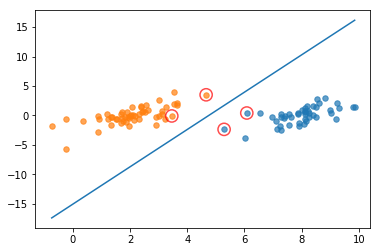

In [44]:
w = get_w(dataArr, labelArr, alphas)
showClassifer(dataArr, w, b)

In [45]:
# 完整版Platt SMO的支持函数
class optStruct:
    
    """
    数据结构，维护所有需要操作的值
    Parameters：
        dataMatIn - 数据矩阵
        classLabels - 数据标签
        C - 松弛变量
        toler - 容错率
    """
    def __init__(self, dataMatIn, classLabels, C, toler):
        self.X = dataMatIn
        self.labelMat = classLabels
        self.C = C
        self.tol = toler
        self.m = shape(dataMatIn)[0]
        self.alphas = mat(zeros((self.m, 1)))
        self.b = 0
        self.eCache = mat(zeros((self.m, 2)))
        
def calcEk(oS, k):
    """
    计算误差
    Parameters：
        oS - 数据结构
        k - 标号为k的数据
    Returns:
        Ek - 标号为k的数据误差
    """
    fXk = float(multiply(oS.alphas, oS.labelMat).T * (oS.X * oS.X[k,:].T)) + oS.b
    Ek = fXk - float(oS.labelMat[k])
    return Ek

def selectJ(i, oS, Ei):
    """
    内循环启发方式2
    Parameters：
        i - 标号为i的数据的索引值
        oS - 数据结构
        Ei - 标号为i的数据误差
    Returns:
        j, maxK - 标号为j或maxK的数据的索引值
        Ej - 标号为j的数据误差
    """
    maxK = -1; maxDeltaE = 0; Ej = 0
    oS.eCache[i] = [1, Ei]
    validEcacheList = nonzero(oS.eCache[:, 0].A)[0] # .A将矩阵转换成array，nonzero()返回非零元素的索引，返回tuple
    
    if len(validEcacheList) > 1:
        for k in validEcacheList:
            if k == i: continue
            Ek = calcEk(oS, k)
            deltaE = abs(Ei - Ek)
            if deltaE > maxDeltaE:
                maxK = k; maxDeltaE = deltaE; Ej = Ek
        return maxK, Ej
    else:
        j = selectJrand(i, oS.m)
        Ej = calcEk(oS, j)

    return j, Ej

def updateEk(oS, k):
    """
    计算Ek,并更新误差缓存
    Parameters：
        oS - 数据结构
        k - 标号为k的数据的索引值
    Returns:
        无
    """
    Ek = calcEk(oS, k)
    oS.eCache[k] = [1, Ek]   

In [46]:
# 完整Platt SMO算法中的优化例程
def innerL(i, oS):
    """
    优化的SMO算法
    Parameters：
        i - 标号为i的数据的索引值
        oS - 数据结构
    Returns:
        1 - 有任意一对alpha值发生变化
        0 - 没有任意一对alpha值发生变化或变化太小
    """
    Ei = calcEk(oS, i)
    if (((oS.labelMat[i]*Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or
        ((oS.labelMat[i]*Ei > oS.tol) and (oS.alphas[i] > 0))):
        j, Ej = selectJ(i, oS, Ei)
        alphaIold = oS.alphas[i].copy(); alphaJold = oS.alphas[j].copy()
        if (oS.labelMat[i] != oS.labelMat[j]):
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L == H: print("L == H"); return 0

        eta = (2.0 * oS.X[i, :] * oS.X[j, :].T - oS.X[i, :] * oS.X[i, :].T -
               oS.X[j, :] * oS.X[j, :].T)
        if eta >= 0: print("eta >= 0"); return 0
        oS.alphas[j] -= oS.labelMat[j] * (Ei - Ej)/eta
        oS.alphas[j] = clipAlpha(oS.alphas[j], H, L)

        updateEk(oS, j)
        if (abs(oS.alphas[j] - alphaJold) < 0.00001):
            print("j not moving enough"); return 0
        oS.alphas[i] += oS.labelMat[j] * oS.labelMat[i] * (alphaJold - oS.alphas[j])
        updateEk(oS, i)

        b1 = (oS.b - Ei - oS.labelMat[i] * (oS.alphas[i] - alphaIold) *
              oS.X[i, :] * oS.X[i, :].T - oS.labelMat[j] *
              (oS.alphas[j] - alphaJold) * oS.X[i, :] * oS.X[j, :].T)
        b2 = (oS.b - Ej - oS.labelMat[i] * (oS.alphas[i] - alphaIold) *
              oS.X[i, :] * oS.X[j, :].T - oS.labelMat[j] *
              (oS.alphas[j] - alphaJold) * oS.X[j, :] * oS.X[j, :].T)
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[i]): oS.b = b1
        elif (0 <oS.alphas[j]) and (oS.C > oS.alphas[j]): oS.b = b2
        else: oS.b = (b1 + b2)/2.0
        return 1
    else: return 0

In [47]:
# 完整版Platt SMO的外循环代码
def smoP(dataMatIn, classLabels, C, toler, maxIter, kTup=('lin',0)):
    oS = optStruct(mat(dataMatIn), mat(classLabels).transpose(), C, toler)
    iter = 0
    entireSet = True; alphaPairsChanged = 0
    while (iter < maxIter) and ((alphaPairsChanged > 0) or (entireSet)):
        alphaPairsChanged = 0
        if entireSet:
            for i in range(oS.m):
                alphaPairsChanged += innerL(i, oS)
            print("fullSet, iter: %d i: %d, pairs changed %d" % (iter, i, alphaPairsChanged))
            iter += 1
        else:
            nonBoundIs = nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0] # 得到alphas中在0与C之间元素的索引
            for i in nonBoundIs:
                alphaPairsChanged += innerL(i, oS)
                print("non-bound, iter: %d, i: %d, pairs changed %d" % (iter, i, alphaPairsChanged))
                iter += 1
        if entireSet: entireSet = False
        elif (alphaPairsChanged == 0): entireSet = True
        print("iteration number: %d" % iter)
    return oS.b,oS.alphas

In [48]:
b, alphas = smoP(dataArr, labelArr, 0.6, 0.001, 40) 

L == H
L == H
L == H
j not moving enough
L == H
L == H
L == H
L == H
L == H
L == H
j not moving enough
L == H
L == H
j not moving enough
L == H
L == H
L == H
L == H
L == H
j not moving enough
fullSet, iter: 0 i: 99, pairs changed 6
iteration number: 1
j not moving enough
non-bound, iter: 1, i: 0, pairs changed 0
j not moving enough
non-bound, iter: 2, i: 3, pairs changed 0
j not moving enough
non-bound, iter: 3, i: 4, pairs changed 0
j not moving enough
non-bound, iter: 4, i: 17, pairs changed 0
j not moving enough
non-bound, iter: 5, i: 18, pairs changed 0
j not moving enough
non-bound, iter: 6, i: 25, pairs changed 0
j not moving enough
non-bound, iter: 7, i: 46, pairs changed 0
non-bound, iter: 8, i: 55, pairs changed 0
non-bound, iter: 9, i: 94, pairs changed 0
iteration number: 10
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L == H
j not moving enough
j not moving enough
L == H
j not mov

In [49]:
# 求出了alpha值和对应的b值，就可以求出对应的w值，以及分类函数值
def calcWs(alphas, dataArr, classLabels):
    X = mat(dataArr); labelMat = mat(classLabels).transpose()
    m, n = shape(X)
    w = zeros((n, 1))
    for i in range(m):
        w += multiply(alphas[i] * labelMat[i], X[i, :].T)
    return w

In [50]:
ws = calcWs(alphas, dataArr, labelArr)

In [51]:
ws

array([[ 0.65307162],
       [-0.17196128]])

In [52]:
dataMat = mat(dataArr)

In [53]:
dataMat[0] * mat(ws) + b

matrix([[-0.92555695]])

In [54]:
labelArr[0]

-1.0

In [55]:
dataMat[2] * mat(ws) + b

matrix([[2.30436336]])

In [56]:
labelArr[2]

1.0

In [57]:
dataMat[1] * mat(ws) + b

matrix([[-1.36706674]])

In [58]:
labelArr[1]

-1.0

核SVM

In [116]:
# 核转换函数
def kernelTrans(X, A, kTup):
    """
    通过核函数将数据转换更高维的空间
    Parameters：
        X - 数据矩阵
        A - 单个数据的向量
        kTup - 包含核函数信息的元组
    Returns:
        K - 计算的核K
    """
    m, n = shape(X)
    K = mat(zeros((m, 1)))
    if kTup[0] == 'lin':K = X * A.T # 线性核函数,只进行内积。
    elif kTup[0] == 'rbf': # 高斯核函数,根据高斯核函数公式进行计算
        for j in range(m):
            deltaRow = X[j, :] - A
            K[j] = deltaRow * deltaRow.T
        K = exp(K / (-1 * kTup[1] ** 2))
    else: raise NameError('Houston We Have a Problem -- That Kernel is not recognized') # 抛出错误
    return K

class optStructNew:
    """
    数据结构，维护所有需要操作的值
    Parameters：
        dataMatIn - 数据矩阵
        classLabels - 数据标签
        C - 松弛变量
        toler - 容错率
        kTup - 包含核函数信息的元组,第一个参数存放核函数类别，第二个参数存放必要的核函数需要用到的参数
    """
    def __init__(self, dataMatIn, classLabels, C, toler, kTup):
        self.X = dataMatIn
        self.labelMat = classLabels
        self.C = C
        self.tol = toler
        self.m = shape(dataMatIn)[0]
        self.alphas = mat(zeros((self.m, 1)))
        self.b = 0
        self.eCache = mat(zeros((self.m, 2)))
        self.K = mat(zeros((self.m, self.m)))
        for i in range(self.m):
            self.K[:, i] = kernelTrans(self.X, self.X[i, :], kTup)

In [118]:
def innerLNew(i, oS):
    """
    优化的SMO算法
    Parameters：
        i - 标号为i的数据的索引值
        oS - 数据结构
    Returns:
        1 - 有任意一对alpha值发生变化
        0 - 没有任意一对alpha值发生变化或变化太小
    """
    Ei = calcEkNew(oS, i)
    if (((oS.labelMat[i]*Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or
        ((oS.labelMat[i]*Ei > oS.tol) and (oS.alphas[i] > 0))):
        j, Ej = selectJNew(i, oS, Ei)
        alphaIold = oS.alphas[i].copy(); alphaJold = oS.alphas[j].copy()
        if (oS.labelMat[i] != oS.labelMat[j]):
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L == H: print("L == H"); return 0

        eta = (2.0 * oS.K[i,j] - oS.K[i,i] - oS.K[j,j])
        if eta >= 0: print("eta >= 0"); return 0
        oS.alphas[j] -= oS.labelMat[j] * (Ei - Ej)/eta
        oS.alphas[j] = clipAlpha(oS.alphas[j], H, L)

        updateEkNew(oS, j)
        if (abs(oS.alphas[j] - alphaJold) < 0.00001):
            print("j not moving enough"); return 0
        oS.alphas[i] += oS.labelMat[j] * oS.labelMat[i] * (alphaJold - oS.alphas[j])
        updateEkNew(oS, i)

        b1 = (oS.b - Ei - oS.labelMat[i] * (oS.alphas[i] - alphaIold) *
              oS.K[i,i] - oS.labelMat[j] * (oS.alphas[j] - alphaJold) * oS.K[i,j])
        b2 = (oS.b - Ej - oS.labelMat[i] * (oS.alphas[i] - alphaIold) *
              oS.K[i,j] - oS.labelMat[j] * (oS.alphas[j] - alphaJold) * oS.K[j,j])
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[i]): oS.b = b1
        elif (0 <oS.alphas[j]) and (oS.C > oS.alphas[j]): oS.b = b2
        else: oS.b = (b1 + b2)/2.0
        return 1
    else: return 0

In [119]:
def selectJNew(i, oS, Ei):
    maxK = -1; maxDeltaE = 0; Ej = 0
    oS.eCache[i] = [1, Ei]
    validEcacheList = nonzero(oS.eCache[:, 0].A)[0] # .A将矩阵转换成array，nonzero()返回非零元素的索引，返回tuple
    
    if len(validEcacheList) > 1:
        for k in validEcacheList:
            if k == i: continue
            Ek = calcEkNew(oS, k)
            deltaE = abs(Ei - Ek)
            if deltaE > maxDeltaE:
                maxK = k; maxDeltaE = deltaE; Ej = Ek
        return maxK, Ej
    else:
        j = selectJrand(i, oS.m)
        Ej = calcEkNew(oS, j)

    return j, Ej

In [120]:
def updateEkNew(oS, k):
    Ek = calcEkNew(oS, k)
    oS.eCache[k] = [1, Ek]   

In [121]:
def calcEkNew(oS, k):
    fXk = float(multiply(oS.alphas, oS.labelMat).T * oS.K[:,k] + oS.b)
    Ek = fXk - float(oS.labelMat[k])
    return Ek

In [122]:
def smoPNew(dataMatIn, classLabels, C, toler, maxIter, kTup=('lin',0)):
    oS = optStructNew(mat(dataMatIn), mat(classLabels).transpose(), C, toler, kTup)
    iter = 0
    entireSet = True; alphaPairsChanged = 0
    while (iter < maxIter) and ((alphaPairsChanged > 0) or (entireSet)):
        alphaPairsChanged = 0
        if entireSet:
            for i in range(oS.m):
                alphaPairsChanged += innerLNew(i, oS)
            print("fullSet, iter: %d i: %d, pairs changed %d" % (iter, i, alphaPairsChanged))
            iter += 1
        else:
            nonBoundIs = nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0] # 得到alphas中在0与C之间元素的索引
            for i in nonBoundIs:
                alphaPairsChanged += innerLNew(i, oS)
                print("non-bound, iter: %d, i: %d, pairs changed %d" % (iter, i, alphaPairsChanged))
                iter += 1
        if entireSet: entireSet = False
        elif (alphaPairsChanged == 0): entireSet = True
        print("iteration number: %d" % iter)
    return oS.b,oS.alphas

In [128]:
# 利用核函数进行分类的径向基测试函数
def testRbf(k1 = 1.3):
    dataArr, labelArr = loadDataSet('testSetRBF.txt')
    b, alphas = smoPNew(dataArr, labelArr, 200, 0.0001, 10000, ('rbf', k1))
    datMat = mat(dataArr); labelMat = mat(labelArr).transpose()
    svInd = nonzero(alphas.A > 0)[0]
    sVs = datMat[svInd]
    labelSV = labelMat[svInd]
    print("there are %d Support Vectors" % shape(sVs)[0])
    m, n = shape(datMat)
    errorCount = 0
    for i in range(m):
        kernelEval = kernelTrans(sVs, datMat[i, :], ('rbf', k1))
        predict = kernelEval.T * multiply(labelSV, alphas[svInd]) + b
        if sign(predict) != sign(labelArr[i]): errorCount += 1
    print("the training error rate is: %f" % (float(errorCount)/m))
        
    dataArr, labelArr = loadDataSet('testSetRBF2.txt')
    errorCount = 0
    datMat = mat(dataArr); labelMat = mat(labelArr).transpose()
    m, n = shape(datMat)
    for i in range(m):
        kernelEval = kernelTrans(sVs, datMat[i,:], ('rbf', k1))
        predict = kernelEval.T * multiply(labelSV, alphas[svInd]) + b
        if sign(predict) != sign(labelArr[i]): errorCount += 1
    print("the test error rate is: %f" % (float(errorCount)/m))  

In [129]:
testRbf()

j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L == H
j not moving enough
L == H
L == H
L == H
L == H
j not moving enough
L == H
j not moving enough
L == H
j not moving enough
j not moving enough
L == H
L == H
L == H
L == H
L == H
L == H
fullSet, iter: 0 i: 99, pairs changed 17
iteration number: 1
non-bound, iter: 1, i: 0, pairs changed 1
j not moving enough
non-bound, iter: 2, i: 3, pairs changed 1
j not moving enough
non-bound, iter: 3, i: 6, pairs changed 1
j not moving enough
non-bound, iter: 4, i: 14, pairs changed 1
j not moving enough
non-bound, iter: 5, i: 17, pairs changed 1
j not moving enough
non-bound, iter: 6, i: 21, pairs changed 1
non-bound, iter: 7, i: 23, pairs changed 2
j not moving enough
non-bound, iter: 8, i: 27, pairs changed 2
j not moving enough
non-bound, iter: 9, i: 28, pairs changed 2
non-bound, iter: 10, i: 29, pairs changed 3
j not moving enough
non-bound, iter: 11, i: 31, pairs changed 3
non-bound, iter:

示例：手写识别问题回顾

In [141]:
# 基于SVM的手写数字识别

def img2vector(filename):
    """
    将32x32的二进制图像转换为1x1024向量。
    Parameters:
        filename - 文件名
    Returns:
        returnVect - 返回的二进制图像的1x1024向量
    """
    returnVect = zeros((1,1024))
    fr = open(filename)
    for i in range(32):
        lineStr = fr.readline()
        for j in range(32):
            returnVect[0,32*i+j] = int(lineStr[j])
    return returnVect

def loadImages(dirName):
    """
    加载图片
    Parameters:
        dirName - 文件夹的名字
    Returns:
        trainingMat - 数据矩阵
        hwLabels - 数据标签
    """
    from os import listdir
    hwLabels = []
    trainingFileList = listdir(dirName)
    m = len(trainingFileList)
    trainingMat = zeros((m, 1024))
    
    for i in range(m):
        fileNameStr = trainingFileList[i]
        fileStr = fileNameStr.split('.')[0]
        classNumStr = int(fileStr.split('_')[0])
        if classNumStr == 9: hwLabels.append(-1)
        else: hwLabels.append(1)
        trainingMat[i, :] = img2vector('%s/%s' % (dirName, fileNameStr))
    return trainingMat, hwLabels

In [144]:
def testDigits(kTup = ('rbf', 10)):
    """
    测试函数
    Parameters:
        kTup - 包含核函数信息的元组
    Returns:
        无
    """
    dataArr, labelArr = loadImages('trainingDigits')
    b, alphas = smoPNew(dataArr, labelArr, 200, 0.0001, 10000, kTup)
    datMat = mat(dataArr); labelMat = mat(labelArr).transpose()
    svInd = nonzero(alphas.A > 0)[0]
    sVs = datMat[svInd]
    labelSV = labelMat[svInd]
    print("there are %d Support Vectors" % shape(sVs)[0])
    m, n = shape(datMat)
    errorCount = 0 
    for i in range(m):
        kernelEval = kernelTrans(sVs, datMat[i,:], kTup)
        predict = kernelEval.T * multiply(labelSV, alphas[svInd]) + b
        if sign(predict) != sign(labelArr[i]): errorCount += 1
    print("the training error rate is: %f" % (float(errorCount)/m))
    
    dataArr, labelArr = loadImages('testDigits')
    errorCount = 0
    datMat = mat(dataArr); labelMat = mat(labelArr).transpose()
    m, n = shape(datMat)
    for i in range(m):
        kernelEval = kernelTrans(sVs, datMat[i,:], kTup)
        predict = kernelEval.T * multiply(labelSV, alphas[svInd]) + b
        if sign(predict) != sign(labelArr[i]): errorCount += 1
    print("the test error rate is: %f" % (float(errorCount)/m))

In [145]:
testDigits(('rbf', 20))

L == H
j not moving enough
j not moving enough
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L == H
j not moving enough
L == H
j not moving enough
L == H
j not moving enough
j not moving enough
L == H
j not moving enough
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H
L == H


j not moving enough
L == H
j not moving enough
L == H
L == H
L == H
j not moving enough
L == H
L == H
L == H
L == H
j not moving enough
L == H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L == H
j not moving enough
L == H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L == H
L == H
L == H
L == H
j not moving enough
L == H
j not moving enough
L == H
L == H
L == H
j not moving enough
j not moving enough
L == H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L == H
j not moving enough
L == H
L == H
j not moving enough
L == H
j not moving enough
j not moving enough
j not moving enough
L == H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L == H
j not moving enough
L == H
L == H
L == H
j not moving enough
L == H
j not moving enough
j not moving enough
L == H
L == H
L == H
L == H
j not moving enough
fu